In [36]:
"""
Processing the data
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'VFlow'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [19]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    model.save('model/' + name + '.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/' + name + ' loss.csv', encoding='utf-8', index=False)

In [20]:
def do_train(model_name):
    lag = 12
    config = {"batch": 256, "epochs": 500}
    file1 = 'data/train.csv'
    file2 = 'data/test.csv'
    X_train, y_train, _, _, _ = process_data(file1, file2, lag)

    if model_name == 'lstm':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = get_lstm([12, 64, 64, 1])
        train_model(m, X_train, y_train, model_name, config)
    if model_name == 'gru':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = get_gru([12, 64, 64, 1])
        train_model(m, X_train, y_train, model_name, config)
    if model_name == 'saes':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
        m = get_saes([12, 400, 400, 400, 1])
        train_seas(m, X_train, y_train, model_name, config)

In [21]:
"""
Defination of NN model
"""
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, GRU
from keras.models import Sequential


def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def _get_sae(inputs, hidden, output):
    """SAE(Auto-Encoders)
    Build SAE Model.

    # Arguments
        inputs: Integer, number of input units.
        hidden: Integer, number of hidden units.
        output: Integer, number of output units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

    return model


def get_saes(layers):
    """SAEs(Stacked Auto-Encoders)
    Build SAEs Model.

    # Arguments
        layers: List(int), number of input, output and hidden units.
    # Returns
        models: List(Model), List of SAE and SAEs.
    """
    sae1 = _get_sae(layers[0], layers[1], layers[-1])
    sae2 = _get_sae(layers[1], layers[2], layers[-1])
    sae3 = _get_sae(layers[2], layers[3], layers[-1])

    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[2], name='hidden2'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[3], name='hidden3'))
    saes.add(Activation('sigmoid'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [sae1, sae2, sae3, saes]

    return models

In [48]:
def train_seas(models, X_train, y_train, name, config):
    """train
    train the SAEs model.

    # Arguments
        models: List, list of SAE model.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    temp = X_train
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')

    for i in range(len(models) - 1):
        if i > 0:
            p = models[i - 1]
            hidden_layer_model = Model(input=p.input,
                                       output=p.get_layer('hidden').output)
            temp = hidden_layer_model.predict(temp)

        m = models[i]
        m.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])

        m.fit(temp, y_train, batch_size=config["batch"],
              epochs=config["epochs"],
              validation_split=0.05)

        models[i] = m

    saes = models[-1]
    for i in range(len(models) - 1):
        weights = models[i].get_layer('hidden').get_weights()
        saes.get_layer('hidden%d' % (i + 1)).set_weights(weights)

    train_model(saes, X_train, y_train, name, config)

## warning: this stuff will take ages to run and needs GPU time

In [50]:
from keras.models import Model
from keras.callbacks import EarlyStopping

In [51]:
do_train('saes')

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0643 - mape: 731294.5000 - val_loss: 0.0412 - val_mape: 650787.5000
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - mape: 274225.0312 - val_loss: 0.0280 - val_mape: 424932.0000
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - mape: 342022.5625 - val_loss: 0.0227 - val_mape: 348317.9062
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - mape: 274367.2188 - val_loss: 0.0205 - val_mape: 263982.7188
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mape: 197855.1875 - val_loss: 0.0178 - val_mape: 259100.2969
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - mape: 187618.5625 - val_loss: 0.0174 - val_mape: 215720.7969
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - mape: 168182.9219 - val_loss: 0.0150 - val_mape: 262071.5469
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mape: 336596.7188 - val_loss

ValueError: The layer sequential_12 has never been called and thus has no defined input.

In [ ]:
do_train('gru')

In [46]:
do_train('lstm')

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0754 - mape: 981760.0625 - val_loss: 0.0264 - val_mape: 197.5863
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0276 - mape: 316685.7500 - val_loss: 0.0234 - val_mape: 185.9779
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230 - mape: 317253.7188 - val_loss: 0.0193 - val_mape: 171.9786
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - mape: 305967.4375 - val_loss: 0.0146 - val_mape: 153.3369
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - mape: 200970.2188 - val_loss: 0.0113 - val_mape: 141.2046
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - mape: 172178.3438 - val_loss: 0.0153 - val_mape: 148.2688
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - mape: 242240.6875 - val_loss: 0.0105 - val_mape: 135.1458
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - mape: 135260.7188 - val_loss: 0.0092 - val

## end of warning

In [28]:
import math
import warnings
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from keras.src.legacy.saving import legacy_h5_format

In [52]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted resul.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=96, freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()


def main():
    #lstm = load_model('model/lstm.h5')
    gru = legacy_h5_format.load_model_from_hdf5("model/gru.h5", custom_objects={'mse': 'mse'})
    #saes = legacy_h5_format.load_model_from_hdf5("model/saes.h5", custom_objects={'mse': 'mse'})
    lstm = legacy_h5_format.load_model_from_hdf5("model/lstm.h5", custom_objects={'mse': 'mse'})
    models = [lstm, gru]#, saes]
    names = ['LSTM', 'GRU']#, 'SAEs']

    lag = 12
    file1 = 'data/train.csv'
    file2 = 'data/test.csv'
    _, _, X_test, y_test, scaler = process_data(file1, file2, lag)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

    y_preds = []
    for name, model in zip(names, models):
        if name == 'SAEs':
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
        else:
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        file = 'images/' + name + '.png'
        plot_model(model, to_file=file, show_shapes=True)
        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
        y_preds.append(predicted[:96])
        print(name)
        eva_regress(y_test, predicted)

    plot_results(y_test[: 96], y_preds, names)

You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM
explained_variance_score:0.946050
mape:27.105413%
mae:16.370124
mse:606.336943
rmse:24.623910
r2:0.945953
You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU
explained_variance_score:0.945770
mape:29.658401%
mae:16.451095
mse:608.542531
rmse:24.668655
r2:0.945756


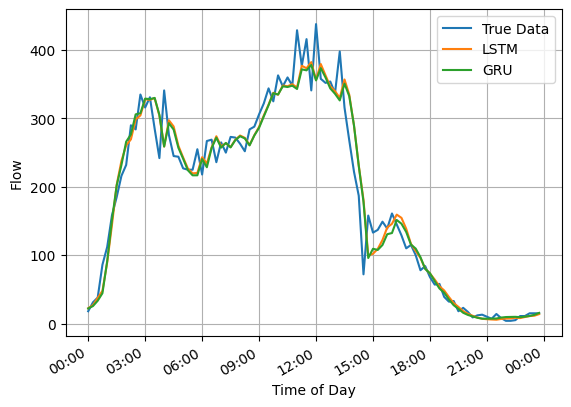

In [53]:
main()